In [2]:
import numpy as np
import mne
from scipy.signal import butter, filtfilt#lfilter, firwin2, freqz, iirnotch, , savgol_filter
from scipy.signal.windows import hann
import scipy

In [2]:
data = mne.io.read_raw_edf("/Users/jamienorris/Documents/GOSH_SEEG_Analysis/stuart_data/AJD_1097824/Interictal_AJD_red_proc.edf", preload=True)

Extracting EDF parameters from /Users/jamienorris/Documents/GOSH_SEEG_Analysis/stuart_data/AJD_1097824/Interictal_AJD_red_proc.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3703295  =      0.000 ...  7232.998 secs...


In [15]:
def line_length(a, w = 20):
    # a = array to use, n = line-length window e.g. 40ms worth
    
    # Get difference between datapoints
    a = np.diff(a)
    
    # Get absolute difference between datapoints
    a = np.abs(a)
    
    # Pad to length of original array
    a = np.pad(a, ((0, 0), (w//2 + 1, w//2 + w % 2)), 'constant')
    
    ret = np.cumsum(a, axis=1, dtype=float)
    
    return ret[:, w:] - ret[:, :-w]

def line_length_transform(data, window=40):
    ll_resample_freq = 50
    # Window corresponds to line-length window in ms.

    # Get line-length window (40ms) in number of datapoints
    window_pts = int(np.round(data.info['sfreq'] * window / 1000))
            
    # Apply line-length transformation to data
    ll = line_length(data.get_data(), w = window_pts)

    # Low-pass filter at 20 Hz
    bl, al = butter(4, 20 / (data.info['sfreq'] / 2), 'lowpass')
    ll = filtfilt(bl, al, ll)

    # Resample at ll_resample_freq (default 50 Hz)
    ll = scipy.signal.resample(ll, int(ll.shape[1] * ll_resample_freq/data.info['sfreq']), axis=1)

    # Resampling can result in negative values, set these to 0
    ll[ll < 0] = 0

    return ll

def hanning_window(data, freq=50):
    # Apply one-second taper to either side of EEG
    
    # 2 seconds in total
    w = 2*freq
    haw=1-hann(w)
    
    # Split into left and right side window
    lhaw=haw[freq:]
    rhaw=haw[:freq]

    # Multiply left and right second by lhaw/rhaw
    data[:, :freq] = np.multiply(data[:, :freq], lhaw)
    data[:, -freq:] = np.multiply(data[:, -freq:], rhaw)

    return data

In [4]:
# Get data as a NumPy array
raw = data.get_data()

# Remove occassional DC component by zero-centering individual channels
raw -= np.expand_dims(np.nanmedian(raw, axis=1), axis=-1)

# Create a new RawEDF object with the zero-centred data
data = mne.io.RawArray(raw, data.info)

# Bandpass filter between 0.1 and 50/200 Hz 
# Note: it should be with a butter filter of order 2
data.filter(0.1, 50)

# Get data as a NumPy array
raw = data.get_data()

# Re-reference to the global median voltage
raw -= np.median(raw)

# This is set as 50 µV in Maxime's paper
scaled_voltage = 50

# Normalise each channel by scaling its median absolute voltage to 50 µV
raw *= np.expand_dims((scaled_voltage / np.median(np.absolute(raw), axis=1)), axis=-1)

# Create a new RawEDF object with the transformed data
data = mne.io.RawArray(raw, data.info)

# Resample to 500 Hz
data.resample(sfreq=500)
        

Creating RawArray with float64 data, n_channels=165, n_times=3703296
    Range : 0 ... 3703295 =      0.000 ...  7232.998 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:   10.1s finished


Creating RawArray with float64 data, n_channels=165, n_times=3703296
    Range : 0 ... 3703295 =      0.000 ...  7232.998 secs
Ready.


<RawArray | 165 x 3616500 (7233.0 s), ~4.45 GB, data loaded>

In [5]:
ll = line_length_transform(data)

In [16]:
# data.plot(start=130, scalings=dict(eeg=5e2))
hw = hanning_window(ll)

In [19]:
(hw - ll).max()

0.0

In [3]:
data = mne.io.read_raw_fif("/Users/jamienorris/Documents/Interictal-Spike-detection/ll.fif", preload=True)

Opening raw data file /Users/jamienorris/Documents/Interictal-Spike-detection/ll.fif...
Isotrak not found
    Range : 0 ... 361649 =      0.000 ...  7232.980 secs
Ready.
Reading 0 ... 361649  =      0.000 ...  7232.980 secs...


/var/folders/s8/yc5ds6dn11ncxwggkx3c6wrc0000gn/T/ipykernel_14841/2977548305.py:1: RuntimeWarning: This filename (/Users/jamienorris/Documents/Interictal-Spike-detection/ll.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data = mne.io.read_raw_fif("/Users/jamienorris/Documents/Interictal-Spike-detection/ll.fif", preload=True)


In [11]:
data#.plot(scalings=dict(eeg=5e2))

<Raw | ll.fif, 165 x 361650 (7233.0 s), ~455.4 MB, data loaded>

In [14]:
W1 = np.load("/Users/jamienorris/Documents/Interictal-Spike-detection/W.npy")
W2 = np.load("/Users/jamienorris/Documents/GOSH_SEEG_Analysis/models/AJD_1097824/W.npy")

In [67]:
H = np.load("/Users/jamienorris/Documents/GOSH_SEEG_Analysis/models/MS/H.npy")

from scipy.signal import butter, lfilter, firwin2, freqz, iirnotch, filtfilt, savgol_filter

def get_thresh(data, k=1):

    # Determine number of bins
    nbin = min(round(.1*len(data)), 1000)

    # Produce pdf
    n, x = np.histogram(data, nbin)

    # Matlab code used bin centres but NumPy fn gives edges - convert to centres
    x = (x[1:] + x[:-1]) / 2

    # "Get rid of bin zero that can be high if many bad times" (speech marks are from Maxime)
    n = n[5:]; x = x[5:]

    # Smooth the pdf - "Third degree polynomial fit on 3dp"
    n_s = savgol_filter(n, 11, 3)

    # "Discard last dp as get skewed by smoothing"
    n = n[:-11]; n_s = n_s[:-11]; x = x[:-11];

    # Get position of mode/peak of pdf - "Mode of distribution"
    modn = np.argmax(n_s)

    # Get position of maximal decay rate, i.e., minimum of first derivate
    # "First derivative = max difference between bins"
    d1 = np.diff(n_s)
    d1 = np.insert(d1, 0, d1[0], axis=0)
    d1_s = savgol_filter(d1, 11, 3)

    # "Min on the right of mode"
    mr = np.argmin(d1_s[modn:])
    mr = mr + modn
    
    # Get position of inflection point, i.e., second(?) maxima of the second derivate
    # "Second derivative = max relative difference between bins"
    d2 = np.diff(d1_s)
    d2 = np.insert(d2, 0, d2[0], axis=0)
    
    # Decide whether to remove this line and amend line below to be d2 instead
    d2_s = savgol_filter(d2, 11, 3)
    ix = np.argmax(d2_s[mr:])
    ix = ix + mr

    # "Double distance mr to ix"
    return x[ix + k * (ix - mr)]

0.015250410632519832

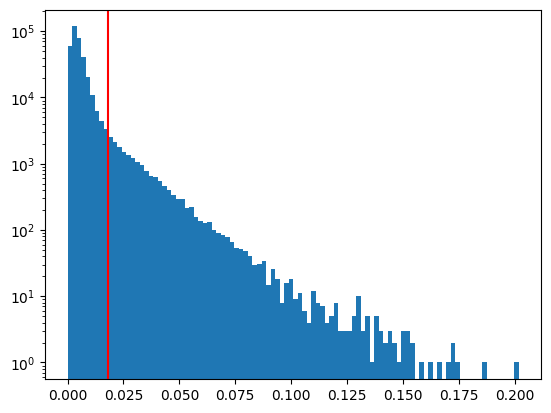

In [82]:
# nbin = min(round(0.1 * len(H[4])), 1000)

# n, x = np.histogram(H[4], nbin)

H_ = H[3]
plt.hist(H_, bins=100, log=True)
plt.axvline(get_thresh(H_, k=10), color='r')
plt.show()

# print(get_thresh(H_, k=10))

In [27]:
corrs = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        corrs[i, j] = np.corrcoef(W1[:, i], W2[:, j])[0, 1]

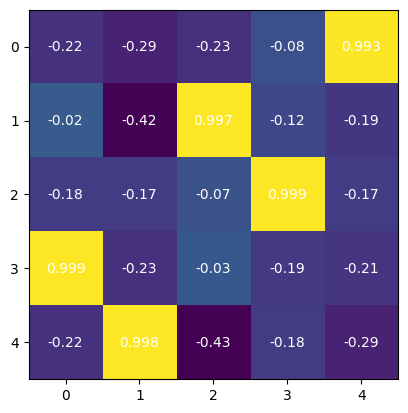

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(corrs)

for i in range(5):
    for j in range(5):
        text = ax.text(j, i, str(corrs[i, j])[:5],
                       ha="center", va="center", color="w")

plt.show()